# Recommendation

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
  
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
ratings = pd.read_csv("C:\\Users\\syed mubarak pasha\\OneDrive\\Documents\\Python\\Assignment\\Recommendation\\recommend\\ratings.csv")
ratings.head()
  

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
movies = pd.read_csv("C:\\Users\\syed mubarak pasha\\OneDrive\\Documents\\Python\\Assignment\\Recommendation\\recommend\\movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
n_ratings = len(ratings)
n_movies = len(ratings['movieId'].unique())
n_users = len(ratings['userId'].unique())

In [5]:
print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average ratings per user: 165.3
Average ratings per movie: 10.37


In [6]:
user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
user_freq.head()

,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


In [7]:
# Find Lowest and Highest rated movies:
mean_rating = ratings.groupby('movieId')[['rating']].mean()

In [8]:
# Lowest rated movies
lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [9]:
# Highest rated movies
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [10]:
# show number of people who rated movies rated movie highest
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


In [11]:
# show number of people who rated movies rated movie lowest
ratings[ratings['movieId']==lowest_rated]

,userId,movieId,rating,timestamp
13633,89,3604,0.5,1520408880


In [12]:
def create_matrix(df): 
    N = len(df['userId'].unique())
    M = len(df['movieId'].unique())
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
      
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]
  
    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
      
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [13]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(ratings)

In [14]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):
      
    neighbour_ids = []
      
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    movie_vec = movie_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [15]:
movie_titles = dict(zip(movies['movieId'], movies['title']))
movie_id = 3
  
similar_ids = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]
  
print(f"Since you watched {movie_title}")
for i in similar_ids:
    print(movie_titles[i])

Since you watched Grumpier Old Men (1995)
Grumpy Old Men (1993)
Striptease (1996)
Nutty Professor, The (1996)
Twister (1996)
Father of the Bride Part II (1995)
Broken Arrow (1996)
Bio-Dome (1996)
Truth About Cats & Dogs, The (1996)
Sabrina (1995)
Birdcage, The (1996)


<AxesSubplot:xlabel='rating', ylabel='Density'>

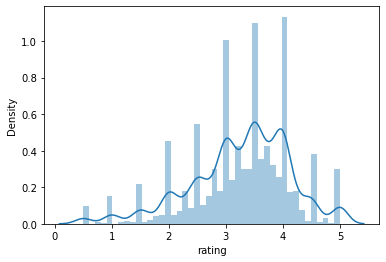

In [16]:
sns.distplot(mean_rating['rating'])

In [17]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [18]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [19]:
def discretise(List, Step):
    D_List = []
    MIN = min(List)
    MAX = max(List)
    NumOfStates = (MAX-MIN)/Step
    
    for items in List:
        D_List.append(int(items/Step))
        
    #if(NumOfStates == max(D_List)):
    return D_List

In [20]:
print(discretise(ratings['userId'], 100))
ratings['userId']= discretise(ratings['userId'], 100)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [21]:
print(discretise(ratings['movieId'], 50000))
ratings['movieId']= discretise(ratings['movieId'], 50000)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [22]:
print(discretise(ratings['rating'], 1))
ratings['rating']= discretise(ratings['rating'], 1)

[4, 4, 4, 5, 5, 3, 5, 4, 5, 5, 5, 5, 3, 5, 4, 5, 3, 3, 5, 4, 4, 5, 4, 3, 4, 5, 4, 3, 5, 4, 4, 5, 4, 4, 4, 5, 5, 3, 5, 3, 4, 3, 3, 4, 5, 5, 5, 4, 5, 3, 5, 5, 5, 5, 3, 5, 5, 4, 5, 4, 5, 5, 5, 4, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 4, 2, 5, 5, 5, 5, 5, 5, 3, 4, 5, 5, 5, 5, 5, 5, 4, 3, 3, 3, 3, 4, 4, 5, 4, 5, 3, 5, 5, 4, 5, 3, 3, 5, 4, 4, 5, 4, 4, 5, 5, 4, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 5, 5, 3, 5, 4, 4, 4, 5, 5, 5, 5, 5, 4, 5, 4, 4, 2, 4, 4, 5, 5, 2, 5, 4, 5, 2, 5, 4, 3, 5, 4, 5, 5, 4, 4, 5, 3, 5, 5, 5, 5, 5, 4, 2, 4, 4, 5, 4, 4, 5, 3, 5, 5, 5, 5, 4, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 4, 1, 3, 3, 5, 5, 5, 4, 4, 5, 5, 5, 4, 4, 4, 5, 4, 4, 5, 5, 5, 5, 4, 4, 5, 4, 4, 5, 3, 4, 4, 4, 4, 3, 4, 4, 4, 5, 4, 3, 4, 3, 4, 4, 5, 4, 5, 3, 2, 3, 5, 3, 4, 2, 3, 5, 5, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 3, 0, 3, 4, 0, 0, 0, 2, 4, 0, 5, 4, 0, 5, 0, 5, 0, 5, 5, 4, 5, 0, 5, 4, 5, 4, 5, 0, 3, 2, 3, 2, 3, 3, 4, 5, 1, 5, 3, 5, 2, 5, 1, 5, 2, 3, 5, 5, 1, 5, 5, 4, 4, 3, 3, 4, 2, 1, 2, 5, 5, 

In [23]:
ratings.head(10)

,userId,movieId,rating,timestamp
0,0,0,4,964982703
1,0,0,4,964981247
2,0,0,4,964982224
3,0,0,5,964983815
4,0,0,5,964982931
5,0,0,3,964982400
6,0,0,5,964980868
7,0,0,4,964982176
8,0,0,5,964984041
9,0,0,5,964984100


In [24]:
features = list(ratings.columns[:2])
features

['userId', 'movieId']

In [25]:
print(features)

['userId', 'movieId']


In [26]:
from sklearn import tree
X = ratings[features]
y = ratings["rating"]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X,y)

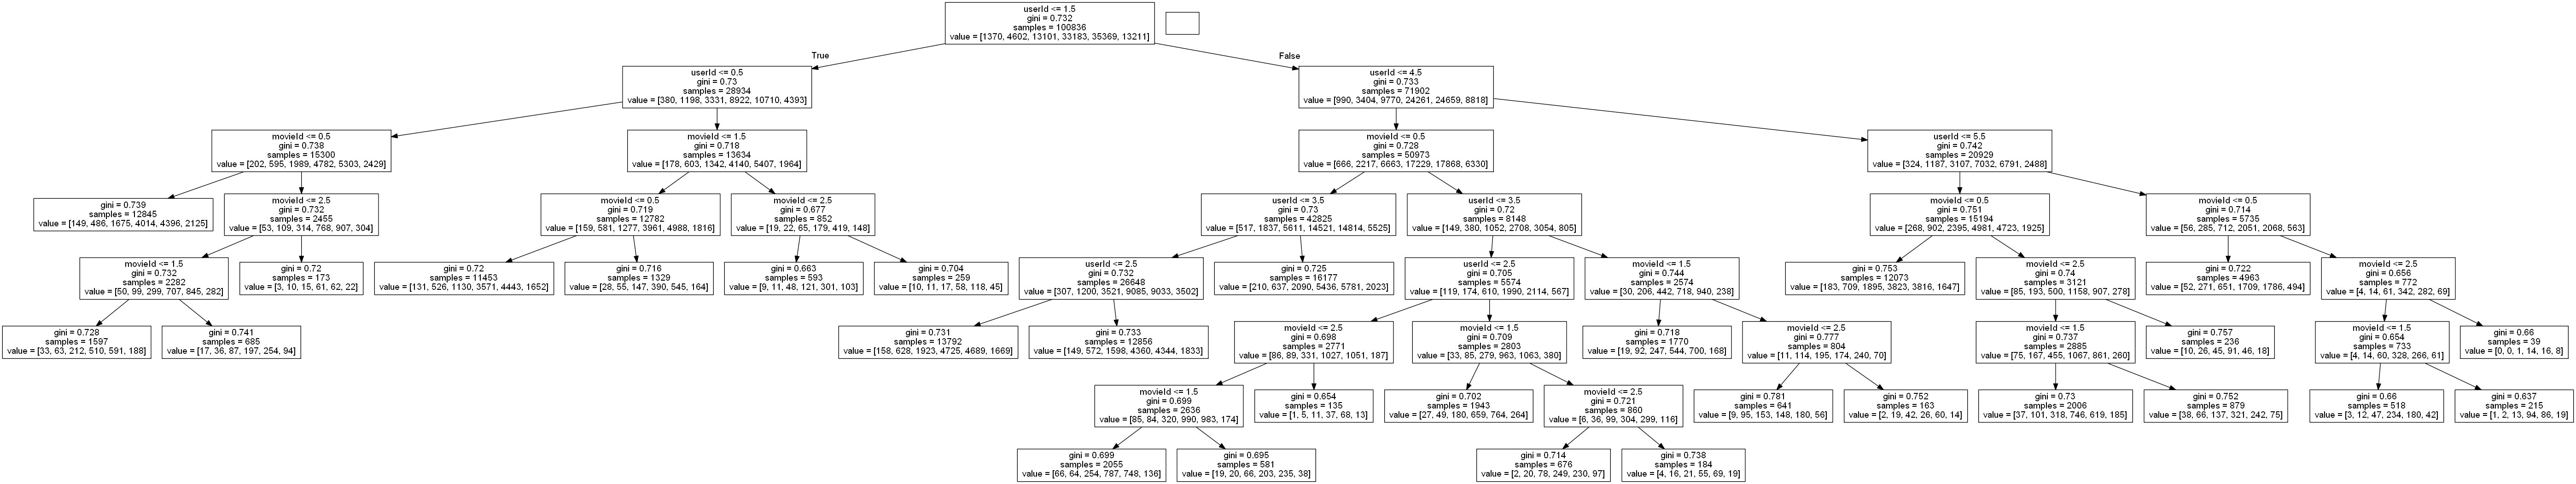

In [27]:
from IPython.display import Image  
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.externals.six import StringIO  
import pydotplus
from sklearn import tree

dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=features)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png()) 

In [28]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

x = ratings[features]
y = ratings["rating"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, train_size = 0.8, random_state = 0)

In [29]:
print('test set: ' + str(x_test.shape))

test set: (20168, 2)


In [30]:
print('train set:' + str(x_train.shape))

train set:(80668, 2)


In [31]:
print(x_train, y_train)

        userId  movieId
77701        4        0
94477        5        0
36246        2        0
17483        1        0
100300       6        1
...        ...      ...
21243        1        0
45891        3        0
42613        2        0
43567        2        0
68268        4        0

[80668 rows x 2 columns] 77701     4
94477     2
36246     2
17483     3
100300    4
         ..
21243     4
45891     4
42613     5
43567     3
68268     4
Name: rating, Length: 80668, dtype: int64


In [32]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(x_train, y_train)
print(accuracy_score(y_test, model.predict(x_test)))

0.3524395081316938


In [33]:
ratings_counts=ratings['rating'].value_counts()
ratings_counts

4    35369
3    33183
5    13211
2    13101
1     4602
0     1370
Name: rating, dtype: int64

<AxesSubplot:ylabel='rating'>

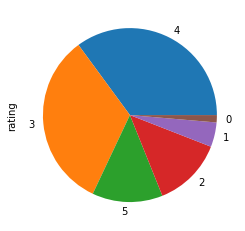

In [34]:
ratings_counts.plot(kind='pie')

<AxesSubplot:>

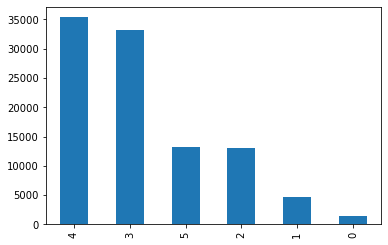

In [35]:
ratings_counts.plot(kind='bar')